In [2]:
# Install necessary libraries and frameworks
!pip install opencv-python numpy matplotlib tensorflow scikit-learn seaborn keras

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pathlib import Path
import tensorflow as tf

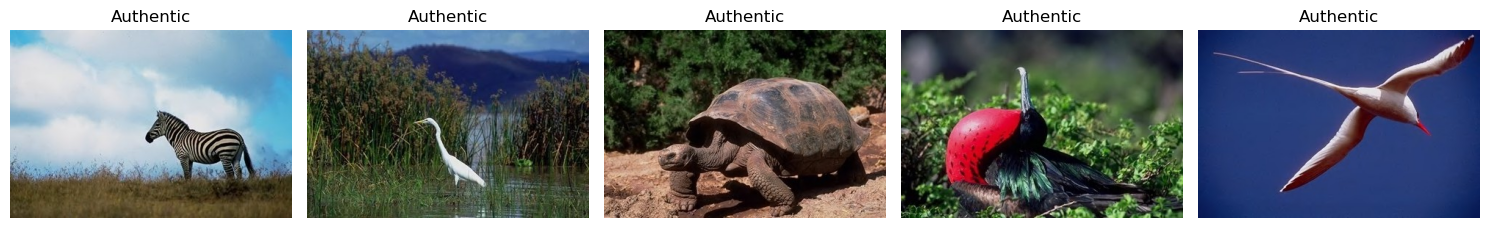

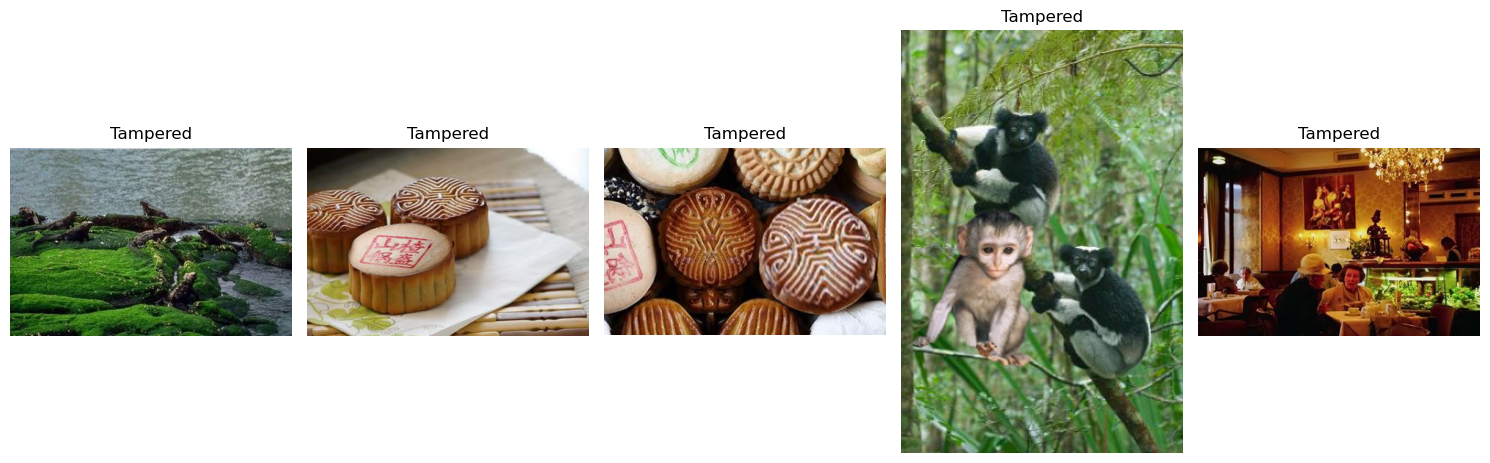

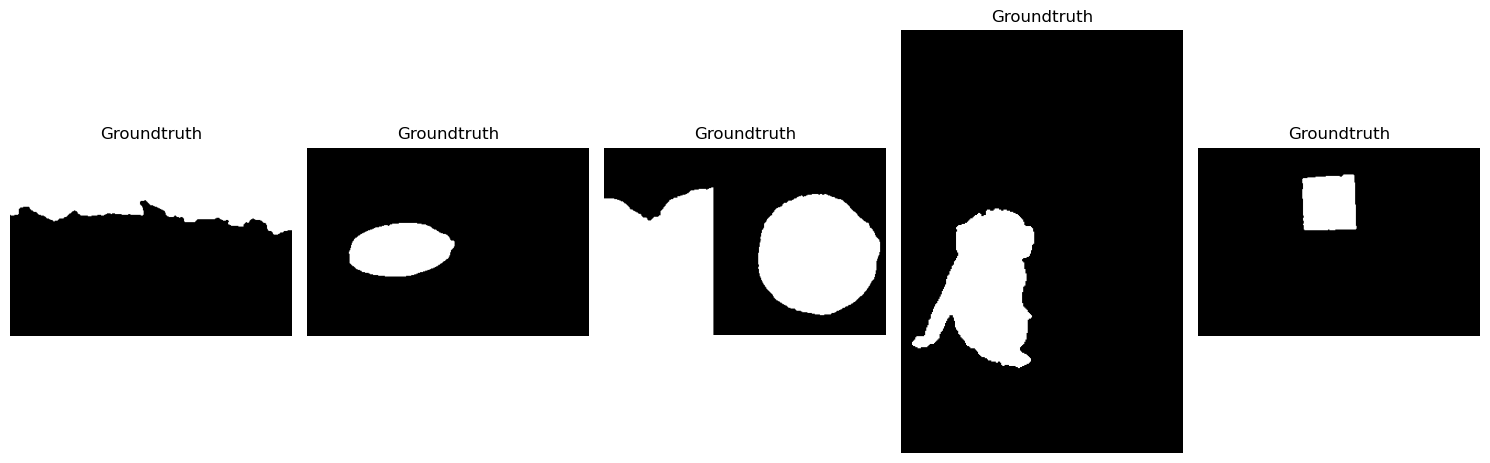


CASIA v2 Dataset Analysis
Number of Authentic Images: 7491
Number of Tampered Images: 5123
Total Number of Images: 12614


In [2]:
# Define the path to the CASIA v2 dataset
dataset_path = os.path.expanduser('C:/Users/sojohn-ebowe/Downloads/CASIA2')

# Function to load images from a folder
def load_images_from_folder(folder_path, num_samples=5):
    images = []
    img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif'))]
    
    for img_name in img_files[:num_samples]:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if the image can't be read
        
        images.append((img, img_name))
    
    return images, len(img_files)

# Function to analyze and visualize images
def analyze_and_visualize_images(dataset_path, num_samples=5):
    categories = {
        'au': 'Authentic',
        'tp': 'Tampered',
        'CASIA 2 Groundtruth': 'Groundtruth'
    }
    
    total_images = 0
    analysis_summary = {}
    
    for folder_name, label in categories.items():
        folder_path = os.path.join(dataset_path, folder_name)
        images, num_images = load_images_from_folder(folder_path, num_samples)
        
        # Skip groundtruth folder for total image count
        if folder_name != 'CASIA 2 Groundtruth':
            analysis_summary[label] = num_images
            total_images += num_images
        
        # Visualize images
        plt.figure(figsize=(15, 5))
        for i, (img, img_name) in enumerate(images):
            plt.subplot(1, num_samples, i + 1)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying
            plt.imshow(img_rgb)
            plt.title(f"{label}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return analysis_summary, total_images

def main():
    # Analyze and visualize the first 5 images from each folder
    analysis_summary, total_images = analyze_and_visualize_images(dataset_path, num_samples=5)
    
    # Print the dataset summary
    print("\nCASIA v2 Dataset Analysis")
    for label, count in analysis_summary.items():
        print(f"Number of {label} Images: {count}")
    print(f"Total Number of Images: {total_images}")

if __name__ == "__main__":
    main()

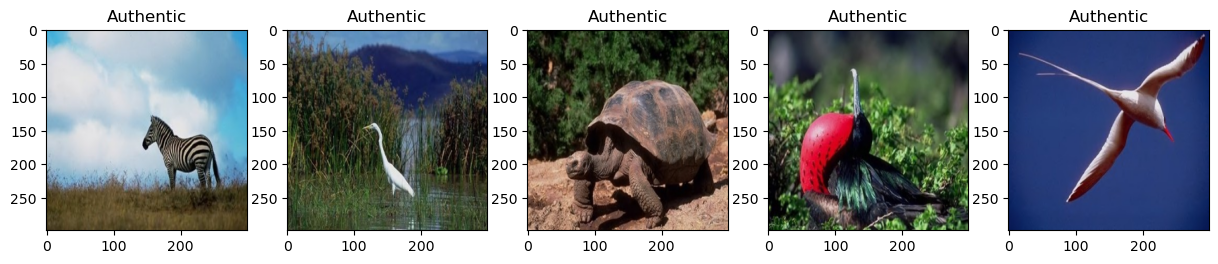

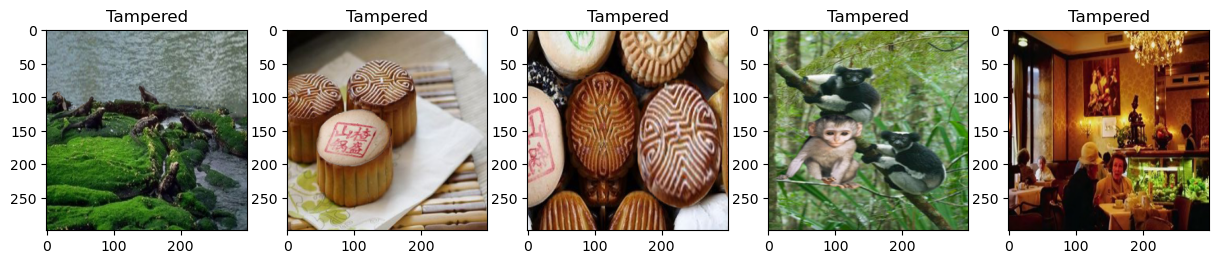

Number of authentic images: 7491
Number of tampered images: 5123
Total number of images: 12614


In [3]:
# Define the path to the CASIA v2 dataset
dataset_path = 'C:/Users/sojohn-ebowe/Downloads/CASIA2'

# Function to load and preprocess images
def load_and_preprocess_images(dataset_path, image_size=(299, 299)):
    authentic_images = []
    tampered_images = []
    
    for root, _, files in os.walk(dataset_path):
        if 'Groundtruth' in root:
            continue  # Skip the groundtruth folder
        
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                file_path = os.path.join(root, file)
                img = cv2.imread(file_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, image_size)
                
                if 'tp' in file.lower():
                    tampered_images.append(img)
                else:
                    authentic_images.append(img)
    
    return np.array(authentic_images), np.array(tampered_images)

# Load and preprocess images
X_authentic, X_tampered = load_and_preprocess_images(dataset_path)

# Visualize some images
def visualize_images(images, title, n_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis('on')
    plt.show()

visualize_images(X_authentic, "Authentic")
visualize_images(X_tampered, "Tampered")

# Print dataset statistics
print(f"Number of authentic images: {len(X_authentic)}")
print(f"Number of tampered images: {len(X_tampered)}")
print(f"Total number of images: {len(X_authentic) + len(X_tampered)}")

In [4]:
# Create labels for authentic and tampered images
y_authentic = np.zeros(len(X_authentic))  # Label authentic images as 0
y_tampered = np.ones(len(X_tampered))  # Label tampered images as 1

# Combine the datasets
X = np.concatenate((X_authentic, X_tampered), axis=0)
y = np.concatenate((y_authentic, y_tampered), axis=0)

# Split the dataset: 80% training, 10% validation, 10% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Preprocess the images for Xception
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

# Output the number of images in each set
print(f"Training set: {len(X_train)} images ({np.sum(y_train == 0)} authentic, {np.sum(y_train == 1)} tampered)")
print(f"Validation set: {len(X_val)} images ({np.sum(y_val == 0)} authentic, {np.sum(y_val == 1)} tampered)")
print(f"Testing set: {len(X_test)} images ({np.sum(y_test == 0)} authentic, {np.sum(y_test == 1)} tampered)")

# Output total number of images
total_images = len(X_train) + len(X_val) + len(X_test)
print(f"Total number of images: {total_images}")

Training set: 10091 images (5993 authentic, 4098 tampered)
Validation set: 1261 images (749 authentic, 512 tampered)
Testing set: 1262 images (749 authentic, 513 tampered)
Total number of images: 12614


In [6]:
# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the first 100 layers of the base model
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 149, 149, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 149, 149, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 149, 149, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 147, 147, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 147, 147, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 147, 147, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 147, 147, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 147, 147, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 147, 147, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 147, 147, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 147, 147, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 74, 74, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 74, 74, 128)       │               

 Total params: 21,911,081 (83.58 MB)

 Trainable params: 10,527,945 (40.16 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 2144s 7s/step - accuracy: 0.6694 - loss: 0.5938 - val_accuracy: 0.7518 - val_loss: 0.4978 - learning_rate: 1.0000e-04
Epoch 2/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 2116s 7s/step - accuracy: 0.8084 - loss: 0.4004 - val_accuracy: 0.7772 - val_loss: 0.4772 - learning_rate: 1.0000e-04
Epoch 3/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 2114s 7s/step - accuracy: 0.8456 - loss: 0.3226 - val_accuracy: 0.7780 - val_loss: 0.5099 - learning_rate: 1.0000e-04
Epoch 4/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 2107s 7s/step - accuracy: 0.8512 - loss: 0.2951 - val_accuracy: 0.7320 - val_loss: 0.5991 - learning_rate: 1.0000e-04
Epoch 5/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 2116s 7s/step - accuracy: 0.8660 - loss: 0.2735 - val_accuracy: 0.7550 - val_loss: 0.5854 - learning_rate: 1.0000e-04
Epoch 6/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 2115s 7s/step - accuracy: 0.8807 - loss: 0.2478 - val_accuracy: 0.7407 - val_loss: 0.6246 - learning_rate: 1.0000e-04
Epoch 7/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 2117s 7s/ste

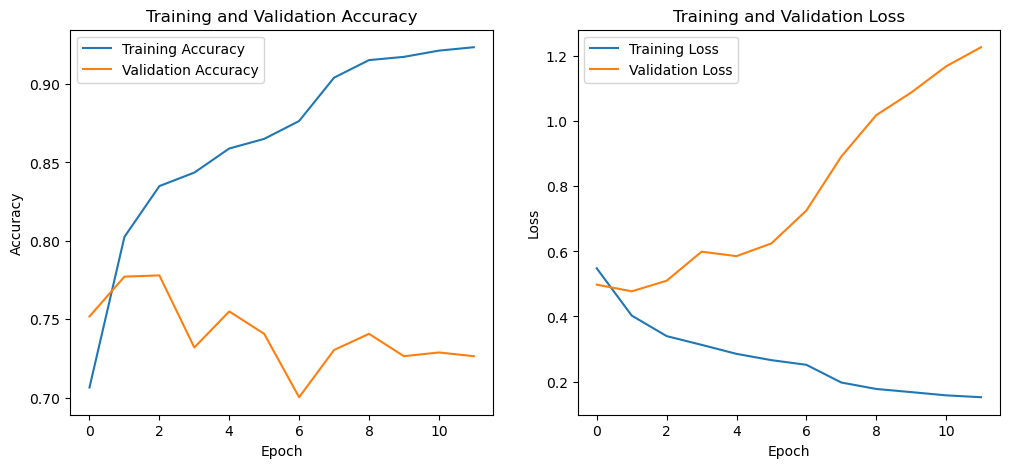

In [8]:
# Plot training accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()    

40/40 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step
ROC AUC: 0.82


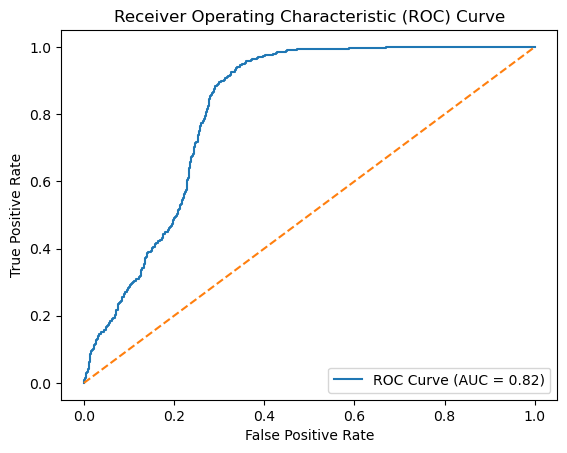

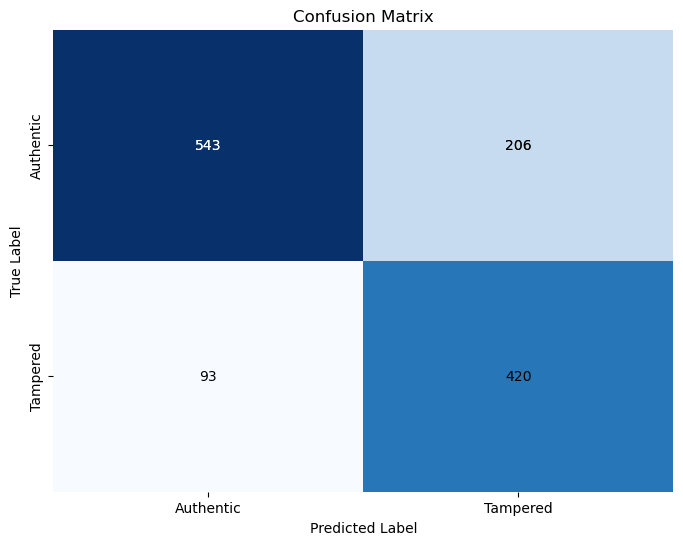

In [9]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)

# ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.2f}')

# Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the Confusion Matrix with values in all quadrants
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Authentic', 'Tampered'], 
            yticklabels=['Authentic', 'Tampered'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Ensure the true positive (first quadrant) is in white and others in black
for i in range(len(cm)):
    for j in range(len(cm[0])):
        color = 'white' if (i == 0 and j == 0) else 'black'  # White font for true positives
        plt.text(j + 0.5, i + 0.5, cm[i, j], ha="center", va="center", color=color)

plt.show()


Performance Evaluation Metrics:
      Metric  Value
0   Accuracy   0.76
1  Precision   0.85
2     Recall   0.73
3   F1 Score   0.79
4        AUC   0.82


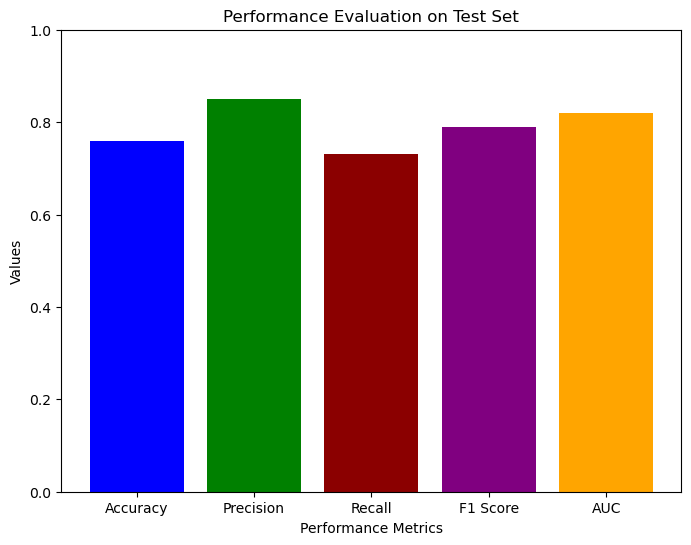

In [3]:
import pandas as pd

# (y_test), predicted probabilities (y_pred) and predicted classes (y_pred_class)
y_test = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])
y_pred_prob = np.array([0.9, 0.2, 0.85, 0.7, 0.1, 0.95, 0.4, 0.3, 0.8, 0.05])
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred_prob)

# Store the metrics in a dictionary
print("\nPerformance Evaluation Metrics:")
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Value': [0.76, 0.85, 0.73, 0.79, 0.82]
}

# Create a DataFrame to display the metrics in a table
metrics_df = pd.DataFrame(metrics)

# Display the table
print(metrics_df)

# Create a bar chart for the metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics_df['Metric'], metrics_df['Value'], color=['blue', 'green', 'darkred', 'purple', 'orange'])
plt.ylim(0, 1)
plt.title('Performance Evaluation on Test Set')
plt.xlabel('Performance Metrics')
plt.ylabel('Values')
plt.show()

In [12]:
# Function to save the trained model
def save_model(model, filepath='xception_model.keras'):
    model.save(filepath)
    print(f'Model saved successfully')

# Save the model
save_model(model)

Model saved successfully
